# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [3]:
train_npz = np.load('../data/train.npz')
train_data = train_npz['data']
test_npz  = np.load('../data/test_input.npz')
test_data  = test_npz['data']

In [4]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [5]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [6]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

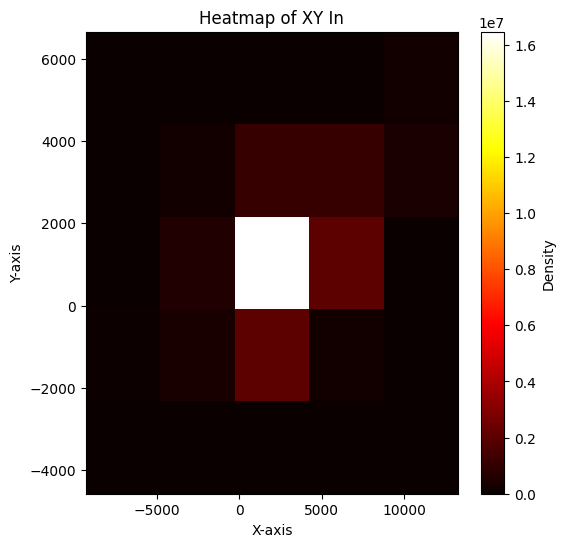

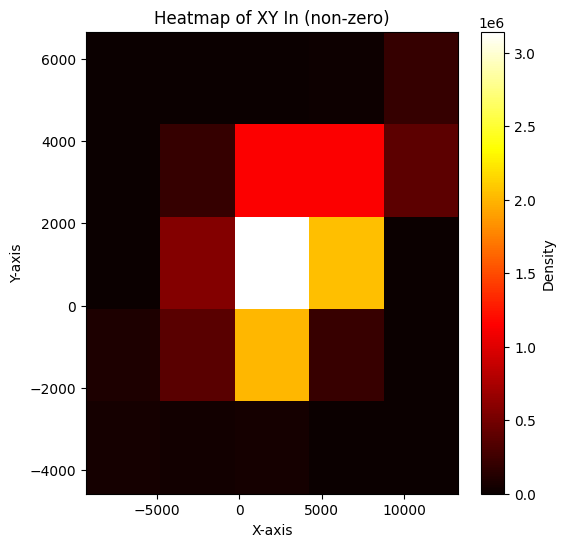

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

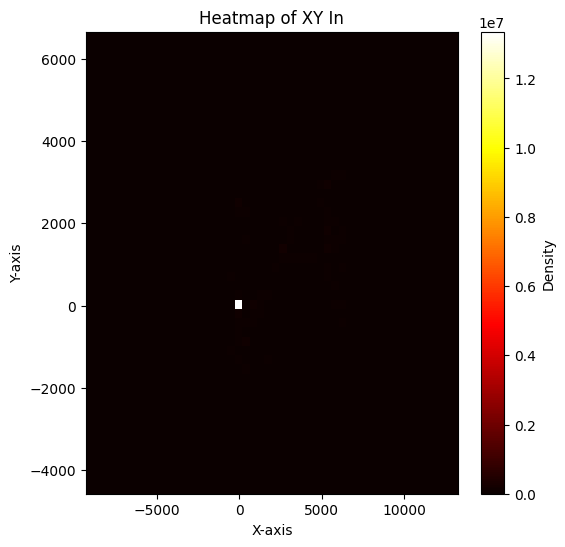

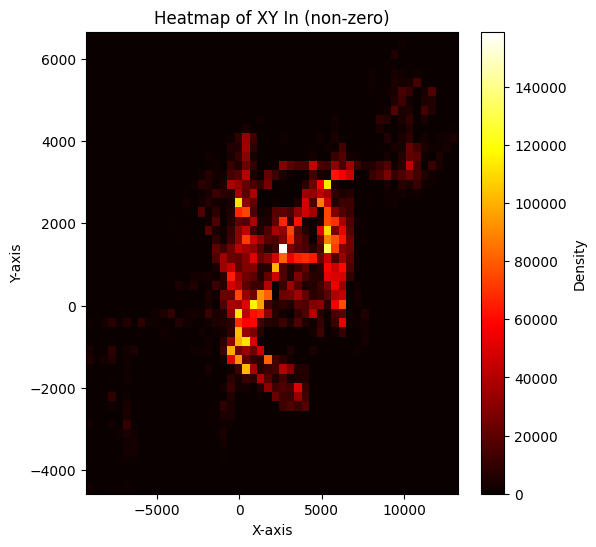

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [11]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [15]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

In [27]:
class LearnedVelocityCV(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        
        self.vel_predictor = nn.Sequential(
            nn.Flatten(),                     # 将 velocity_diff 展平 (B, 49*2)
            nn.Linear(49 * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 60 * 2)            # 输出每帧速度 (B, 60*2)
        )
        
    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)          # (B*50, 50*6)
        B = x.size(0)
        x = x.view(B, 50, 50, 6)

        last_pos = x[:, 0, -1, 0:2]           # (B, 2)
        velocity_diff = x[:, 0, 1:, :2] - x[:, 0, :-1, :2]  # (B, 49, 2)

        # 用 vel_predictor 预测未来每步速度
        pred_vel = self.vel_predictor(velocity_diff)       # (B, 60*2)
        pred_vel = pred_vel.view(B, 60, 2)                 # (B, 60, 2)

        # 位置 = 起点 + 累加速度
        pred_pos = last_pos.unsqueeze(1) + torch.cumsum(pred_vel, dim=1)  # (B, 60, 2)

        return pred_pos

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [51]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [52]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)
# input_features = 50 * 50 * 6
# output_features = 60 * 2

# # Create the model
# model = LearnedVelocityCV(input_features, output_features).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()




#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [53]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]C:\Users\24555\AppData\Local\Temp\ipykernel_8568\3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
C:\Users\24555\AppData\Local\Temp\ipykernel_8568\3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:04<06:47,  4.11s/epoch]

Epoch 000 | Learning rate 0.000100 | train normalized MSE   5.2139 | val normalized MSE   3.1974, | val MAE   7.4278 | val MSE 156.6725


Epoch:   2%|▏         | 2/100 [00:08<06:45,  4.14s/epoch]

Epoch 001 | Learning rate 0.000100 | train normalized MSE   2.7013 | val normalized MSE   2.1164, | val MAE   6.3436 | val MSE 103.7033


Epoch:   3%|▎         | 3/100 [00:12<06:28,  4.01s/epoch]

Epoch 002 | Learning rate 0.000100 | train normalized MSE   1.8922 | val normalized MSE   1.4608, | val MAE   5.0652 | val MSE  71.5798


Epoch:   4%|▍         | 4/100 [00:16<06:22,  3.98s/epoch]

Epoch 003 | Learning rate 0.000100 | train normalized MSE   1.2190 | val normalized MSE   0.9232, | val MAE   3.8230 | val MSE  45.2362


Epoch:   5%|▌         | 5/100 [00:20<06:40,  4.22s/epoch]

Epoch 004 | Learning rate 0.000100 | train normalized MSE   0.8512 | val normalized MSE   0.7301, | val MAE   3.3504 | val MSE  35.7759


Epoch:   6%|▌         | 6/100 [00:25<07:00,  4.47s/epoch]

Epoch 005 | Learning rate 0.000100 | train normalized MSE   0.6893 | val normalized MSE   0.6289, | val MAE   3.0806 | val MSE  30.8184


Epoch:   7%|▋         | 7/100 [00:30<07:11,  4.64s/epoch]

Epoch 006 | Learning rate 0.000100 | train normalized MSE   0.6074 | val normalized MSE   0.5439, | val MAE   2.8581 | val MSE  26.6510


Epoch:   8%|▊         | 8/100 [00:35<07:15,  4.73s/epoch]

Epoch 007 | Learning rate 0.000100 | train normalized MSE   0.5445 | val normalized MSE   0.4948, | val MAE   2.6380 | val MSE  24.2430


Epoch:   9%|▉         | 9/100 [00:40<07:14,  4.78s/epoch]

Epoch 008 | Learning rate 0.000100 | train normalized MSE   0.4983 | val normalized MSE   0.4657, | val MAE   2.5437 | val MSE  22.8181


Epoch:  10%|█         | 10/100 [00:45<07:13,  4.82s/epoch]

Epoch 009 | Learning rate 0.000100 | train normalized MSE   0.4712 | val normalized MSE   0.4426, | val MAE   2.4588 | val MSE  21.6854


Epoch:  11%|█         | 11/100 [00:50<07:10,  4.83s/epoch]

Epoch 010 | Learning rate 0.000100 | train normalized MSE   0.4440 | val normalized MSE   0.4284, | val MAE   2.5683 | val MSE  20.9894


Epoch:  12%|█▏        | 12/100 [00:55<07:07,  4.86s/epoch]

Epoch 011 | Learning rate 0.000100 | train normalized MSE   0.4297 | val normalized MSE   0.3947, | val MAE   2.3585 | val MSE  19.3402


Epoch:  13%|█▎        | 13/100 [00:59<07:01,  4.84s/epoch]

Epoch 012 | Learning rate 0.000100 | train normalized MSE   0.4120 | val normalized MSE   0.4149, | val MAE   2.3800 | val MSE  20.3299


Epoch:  14%|█▍        | 14/100 [01:04<06:58,  4.87s/epoch]

Epoch 013 | Learning rate 0.000100 | train normalized MSE   0.4030 | val normalized MSE   0.3694, | val MAE   2.1921 | val MSE  18.1019


Epoch:  15%|█▌        | 15/100 [01:09<06:54,  4.87s/epoch]

Epoch 014 | Learning rate 0.000100 | train normalized MSE   0.3915 | val normalized MSE   0.3652, | val MAE   2.1678 | val MSE  17.8931


Epoch:  16%|█▌        | 16/100 [01:14<06:49,  4.88s/epoch]

Epoch 015 | Learning rate 0.000100 | train normalized MSE   0.3845 | val normalized MSE   0.3732, | val MAE   2.2860 | val MSE  18.2871


Epoch:  17%|█▋        | 17/100 [01:19<06:44,  4.87s/epoch]

Epoch 016 | Learning rate 0.000100 | train normalized MSE   0.3742 | val normalized MSE   0.3549, | val MAE   2.1242 | val MSE  17.3909


Epoch:  18%|█▊        | 18/100 [01:24<06:40,  4.89s/epoch]

Epoch 017 | Learning rate 0.000100 | train normalized MSE   0.3659 | val normalized MSE   0.3723, | val MAE   2.1831 | val MSE  18.2418


Epoch:  19%|█▉        | 19/100 [01:29<06:37,  4.91s/epoch]

Epoch 018 | Learning rate 0.000100 | train normalized MSE   0.3621 | val normalized MSE   0.3383, | val MAE   2.1948 | val MSE  16.5772


Epoch:  20%|██        | 20/100 [01:34<06:33,  4.92s/epoch]

Epoch 019 | Learning rate 0.000025 | train normalized MSE   0.3535 | val normalized MSE   0.3447, | val MAE   2.2062 | val MSE  16.8897


Epoch:  21%|██        | 21/100 [01:39<06:28,  4.92s/epoch]

Epoch 020 | Learning rate 0.000025 | train normalized MSE   0.3367 | val normalized MSE   0.3177, | val MAE   1.9689 | val MSE  15.5649


Epoch:  22%|██▏       | 22/100 [01:44<06:23,  4.92s/epoch]

Epoch 021 | Learning rate 0.000025 | train normalized MSE   0.3323 | val normalized MSE   0.3186, | val MAE   1.9729 | val MSE  15.6110


Epoch:  23%|██▎       | 23/100 [01:49<06:16,  4.89s/epoch]

Epoch 022 | Learning rate 0.000025 | train normalized MSE   0.3298 | val normalized MSE   0.3149, | val MAE   1.9402 | val MSE  15.4325


Epoch:  24%|██▍       | 24/100 [01:53<06:11,  4.89s/epoch]

Epoch 023 | Learning rate 0.000025 | train normalized MSE   0.3285 | val normalized MSE   0.3112, | val MAE   1.9174 | val MSE  15.2506


Epoch:  25%|██▌       | 25/100 [01:58<06:07,  4.90s/epoch]

Epoch 024 | Learning rate 0.000025 | train normalized MSE   0.3260 | val normalized MSE   0.3121, | val MAE   1.9567 | val MSE  15.2948


Epoch:  26%|██▌       | 26/100 [02:03<06:03,  4.92s/epoch]

Epoch 025 | Learning rate 0.000025 | train normalized MSE   0.3253 | val normalized MSE   0.3161, | val MAE   1.9957 | val MSE  15.4865


Epoch:  27%|██▋       | 27/100 [02:08<05:59,  4.92s/epoch]

Epoch 026 | Learning rate 0.000025 | train normalized MSE   0.3248 | val normalized MSE   0.3145, | val MAE   1.9307 | val MSE  15.4092


Epoch:  28%|██▊       | 28/100 [02:13<05:53,  4.91s/epoch]

Epoch 027 | Learning rate 0.000025 | train normalized MSE   0.3224 | val normalized MSE   0.3172, | val MAE   1.9684 | val MSE  15.5427


Epoch:  29%|██▉       | 29/100 [02:18<05:46,  4.88s/epoch]

Epoch 028 | Learning rate 0.000025 | train normalized MSE   0.3219 | val normalized MSE   0.3077, | val MAE   1.9027 | val MSE  15.0788


Epoch:  30%|███       | 30/100 [02:23<05:41,  4.88s/epoch]

Epoch 029 | Learning rate 0.000025 | train normalized MSE   0.3191 | val normalized MSE   0.3011, | val MAE   1.8862 | val MSE  14.7537


Epoch:  31%|███       | 31/100 [02:28<05:36,  4.88s/epoch]

Epoch 030 | Learning rate 0.000025 | train normalized MSE   0.3186 | val normalized MSE   0.3046, | val MAE   1.9083 | val MSE  14.9256


Epoch:  32%|███▏      | 32/100 [02:32<05:29,  4.84s/epoch]

Epoch 031 | Learning rate 0.000025 | train normalized MSE   0.3175 | val normalized MSE   0.3009, | val MAE   1.9044 | val MSE  14.7434


Epoch:  33%|███▎      | 33/100 [02:37<05:25,  4.86s/epoch]

Epoch 032 | Learning rate 0.000025 | train normalized MSE   0.3166 | val normalized MSE   0.3007, | val MAE   1.9056 | val MSE  14.7329


Epoch:  34%|███▍      | 34/100 [02:42<05:20,  4.85s/epoch]

Epoch 033 | Learning rate 0.000025 | train normalized MSE   0.3136 | val normalized MSE   0.2982, | val MAE   1.8955 | val MSE  14.6123


Epoch:  35%|███▌      | 35/100 [02:47<05:14,  4.84s/epoch]

Epoch 034 | Learning rate 0.000025 | train normalized MSE   0.3127 | val normalized MSE   0.3014, | val MAE   1.9008 | val MSE  14.7679


Epoch:  36%|███▌      | 36/100 [02:52<05:09,  4.84s/epoch]

Epoch 035 | Learning rate 0.000025 | train normalized MSE   0.3130 | val normalized MSE   0.3015, | val MAE   1.9066 | val MSE  14.7734


Epoch:  37%|███▋      | 37/100 [02:57<05:05,  4.84s/epoch]

Epoch 036 | Learning rate 0.000025 | train normalized MSE   0.3085 | val normalized MSE   0.2939, | val MAE   1.9010 | val MSE  14.3998


Epoch:  38%|███▊      | 38/100 [03:01<04:59,  4.83s/epoch]

Epoch 037 | Learning rate 0.000025 | train normalized MSE   0.3091 | val normalized MSE   0.2981, | val MAE   1.8846 | val MSE  14.6075


Epoch:  39%|███▉      | 39/100 [03:06<04:53,  4.81s/epoch]

Epoch 038 | Learning rate 0.000025 | train normalized MSE   0.3071 | val normalized MSE   0.2963, | val MAE   1.8948 | val MSE  14.5189


Epoch:  40%|████      | 40/100 [03:11<04:48,  4.80s/epoch]

Epoch 039 | Learning rate 0.000006 | train normalized MSE   0.3068 | val normalized MSE   0.2946, | val MAE   1.9438 | val MSE  14.4332


Epoch:  41%|████      | 41/100 [03:16<04:44,  4.82s/epoch]

Epoch 040 | Learning rate 0.000006 | train normalized MSE   0.3032 | val normalized MSE   0.2872, | val MAE   1.8637 | val MSE  14.0743


Epoch:  42%|████▏     | 42/100 [03:21<04:42,  4.88s/epoch]

Epoch 041 | Learning rate 0.000006 | train normalized MSE   0.2992 | val normalized MSE   0.2856, | val MAE   1.8232 | val MSE  13.9956


Epoch:  43%|████▎     | 43/100 [03:25<04:21,  4.58s/epoch]

Epoch 042 | Learning rate 0.000006 | train normalized MSE   0.2999 | val normalized MSE   0.2900, | val MAE   1.8384 | val MSE  14.2080


Epoch:  44%|████▍     | 44/100 [03:29<04:06,  4.41s/epoch]

Epoch 043 | Learning rate 0.000006 | train normalized MSE   0.2994 | val normalized MSE   0.2862, | val MAE   1.8222 | val MSE  14.0262


Epoch:  45%|████▌     | 45/100 [03:33<04:07,  4.50s/epoch]

Epoch 044 | Learning rate 0.000006 | train normalized MSE   0.2981 | val normalized MSE   0.2886, | val MAE   1.8556 | val MSE  14.1400


Epoch:  46%|████▌     | 46/100 [03:37<03:51,  4.29s/epoch]

Epoch 045 | Learning rate 0.000006 | train normalized MSE   0.3002 | val normalized MSE   0.2845, | val MAE   1.8178 | val MSE  13.9413


Epoch:  47%|████▋     | 47/100 [03:41<03:41,  4.18s/epoch]

Epoch 046 | Learning rate 0.000006 | train normalized MSE   0.2974 | val normalized MSE   0.2874, | val MAE   1.8658 | val MSE  14.0831


Epoch:  48%|████▊     | 48/100 [03:46<03:44,  4.32s/epoch]

Epoch 047 | Learning rate 0.000006 | train normalized MSE   0.2978 | val normalized MSE   0.2865, | val MAE   1.8434 | val MSE  14.0386


Epoch:  49%|████▉     | 49/100 [03:51<03:48,  4.48s/epoch]

Epoch 048 | Learning rate 0.000006 | train normalized MSE   0.2984 | val normalized MSE   0.2852, | val MAE   1.8163 | val MSE  13.9759


Epoch:  50%|█████     | 50/100 [03:56<03:52,  4.65s/epoch]

Epoch 049 | Learning rate 0.000006 | train normalized MSE   0.2997 | val normalized MSE   0.2858, | val MAE   1.8587 | val MSE  14.0038


Epoch:  51%|█████     | 51/100 [04:01<03:54,  4.79s/epoch]

Epoch 050 | Learning rate 0.000006 | train normalized MSE   0.2975 | val normalized MSE   0.2857, | val MAE   1.8356 | val MSE  13.9976


Epoch:  52%|█████▏    | 52/100 [04:05<03:45,  4.71s/epoch]

Epoch 051 | Learning rate 0.000006 | train normalized MSE   0.2982 | val normalized MSE   0.2838, | val MAE   1.8177 | val MSE  13.9051


Epoch:  53%|█████▎    | 53/100 [04:11<03:58,  5.07s/epoch]

Epoch 052 | Learning rate 0.000006 | train normalized MSE   0.2962 | val normalized MSE   0.2849, | val MAE   1.8407 | val MSE  13.9603


Epoch:  54%|█████▍    | 54/100 [04:20<04:44,  6.19s/epoch]

Epoch 053 | Learning rate 0.000006 | train normalized MSE   0.2977 | val normalized MSE   0.2848, | val MAE   1.8352 | val MSE  13.9548


Epoch:  55%|█████▌    | 55/100 [04:29<05:16,  7.04s/epoch]

Epoch 054 | Learning rate 0.000006 | train normalized MSE   0.2962 | val normalized MSE   0.2838, | val MAE   1.8221 | val MSE  13.9047


Epoch:  55%|█████▌    | 55/100 [04:38<03:47,  5.06s/epoch]

Epoch 055 | Learning rate 0.000006 | train normalized MSE   0.2957 | val normalized MSE   0.2846, | val MAE   1.8464 | val MSE  13.9478
Early stop!


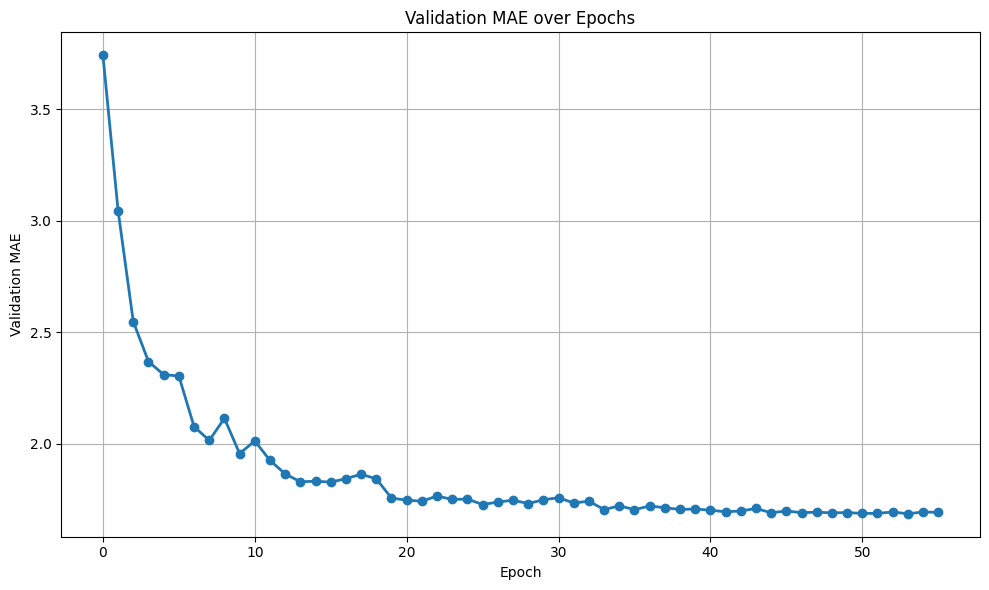

In [50]:
val_mae_list = [
    3.7432, 3.0451, 2.5470, 2.3683, 2.3092, 2.3032, 2.0763, 2.0139, 2.1131, 1.9550,
    2.0118, 1.9244, 1.8637, 1.8283, 1.8308, 1.8269, 1.8423, 1.8622, 1.8416, 1.7552,
    1.7459, 1.7408, 1.7645, 1.7492, 1.7506, 1.7263, 1.7372, 1.7457, 1.7306, 1.7474,
    1.7569, 1.7332, 1.7412, 1.7034, 1.7205, 1.7033, 1.7195, 1.7119, 1.7040, 1.7062,
    1.7006, 1.6937, 1.6971, 1.7086, 1.6891, 1.6974, 1.6897, 1.6918, 1.6888, 1.6901,
    1.6863, 1.6864, 1.6929, 1.6846, 1.6928, 1.6910
]
epochs = list(range(len(val_mae_list)))

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_mae_list, marker='o', linestyle='-', linewidth=2)
plt.title('Validation MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [54]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

C:\Users\24555\AppData\Local\Temp\ipykernel_8568\3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


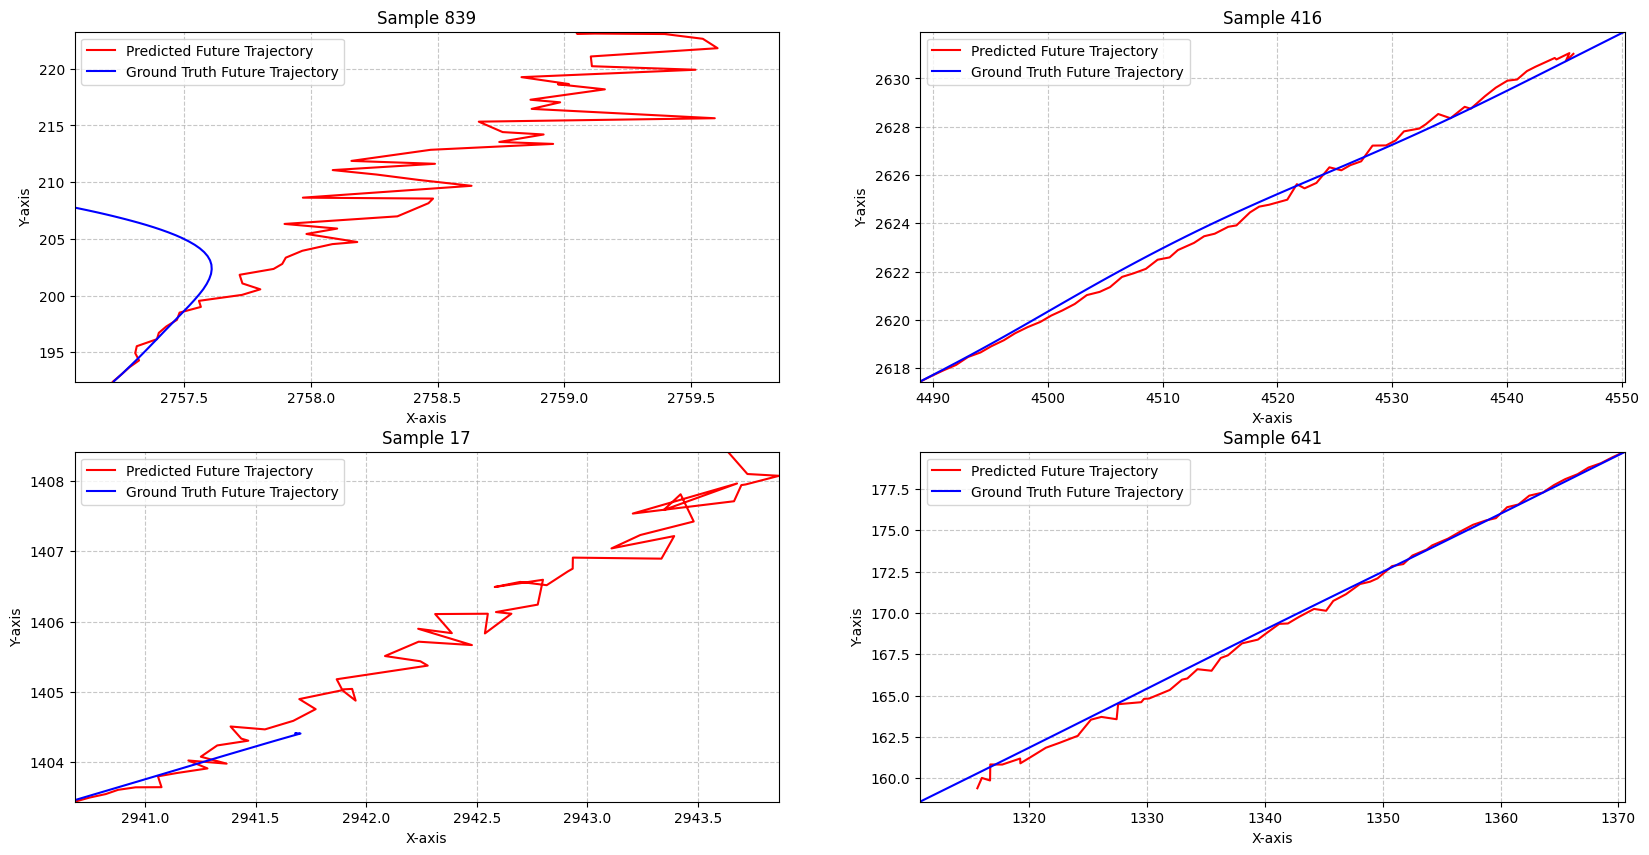

In [55]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [57]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B